### 이상치를 3가지 조정 -> 시각화

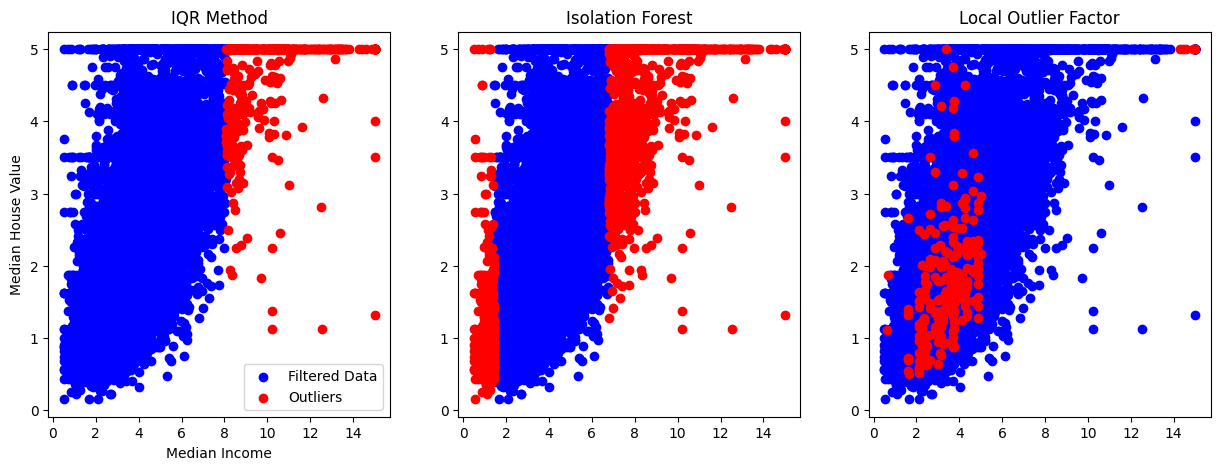

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# 데이터 로드
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["Target"])

# 특성 선택
X = X[['MedInc']]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# IQR 방법을 사용하는 함수
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
    return data[mask], data[~mask]

# 이상치 탐지
X_train_filtered_iqr, outliers_iqr = detect_outliers_iqr(X_train)

# Isolation Forest
iso = IsolationForest(contamination=0.1)
yhat_iso = iso.fit_predict(X_train)
mask_iso = yhat_iso != -1
X_train_filtered_iso, outliers_iso = X_train[mask_iso], X_train[~mask_iso]

# Local Outlier Factor
lof = LocalOutlierFactor()
yhat_lof = lof.fit_predict(X_train)
mask_lof = yhat_lof != -1
X_train_filtered_lof, outliers_lof = X_train[mask_lof], X_train[~mask_lof]

# 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_train_filtered_iqr, y_train.loc[X_train_filtered_iqr.index], color='blue', label='Filtered Data')
plt.scatter(outliers_iqr, y_train.loc[outliers_iqr.index], color='red', label='Outliers')
plt.title('IQR Method')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_train_filtered_iso, y_train.loc[X_train_filtered_iso.index], color='blue', label='Filtered Data')
plt.scatter(outliers_iso, y_train.loc[outliers_iso.index], color='red', label='Outliers')
plt.title('Isolation Forest')

plt.subplot(1, 3, 3)
plt.scatter(X_train_filtered_lof, y_train.loc[X_train_filtered_lof.index], color='blue', label='Filtered Data')
plt.scatter(outliers_lof, y_train.loc[outliers_lof.index], color='red', label='Outliers')
plt.title('Local Outlier Factor')

plt.show()

Original MSE: 0.7091
IQR MSE: 0.7133
IsolationForest MSE: 0.7130
LOF MSE: 0.7092


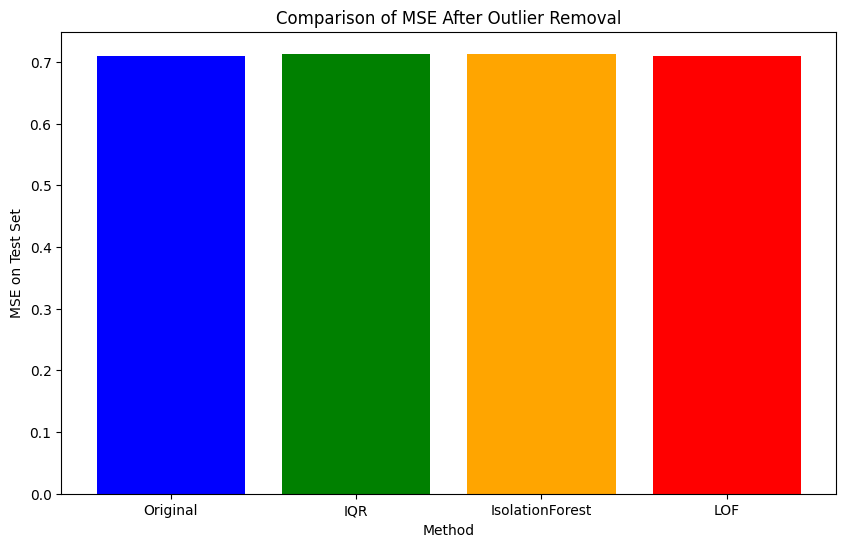

In [22]:
# 데이터 로드 및 초기화
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["Target"])
X = X[['MedInc']]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 평가 함수
def evaluate_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    return mse_test

# 원본 데이터 평가
original_mse = evaluate_model(X_train, y_train, X_test, y_test)

# 이상치 제거 함수
def detect_outliers(method, X, y, contamination=0.1):
    if method == 'IQR':
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    elif method == 'IsolationForest':
        iso = IsolationForest(contamination=contamination)
        mask = iso.fit_predict(X) != -1
    elif method == 'LOF':
        lof = LocalOutlierFactor()
        mask = lof.fit_predict(X) != -1
    return X[mask], y[mask]

# 이상치 제거 및 데이터 저장
methods = ['IQR', 'IsolationForest', 'LOF']
results = {}
for method in methods:
    X_filtered, y_filtered = detect_outliers(method, X_train, y_train)
    mse_test = evaluate_model(X_filtered, y_filtered, X_test, y_test)
    results[method] = mse_test

# 결과 출력
print(f"Original MSE: {original_mse:.4f}")
for method, mse in results.items():
    print(f"{method} MSE: {mse:.4f}")

# 시각화
plt.figure(figsize=(10, 6))
methods = ['Original'] + list(results.keys())
mse_scores = [original_mse] + list(results.values())
plt.bar(methods, mse_scores, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Method')
plt.ylabel('MSE on Test Set')
plt.title('Comparison of MSE After Outlier Removal')
plt.show()


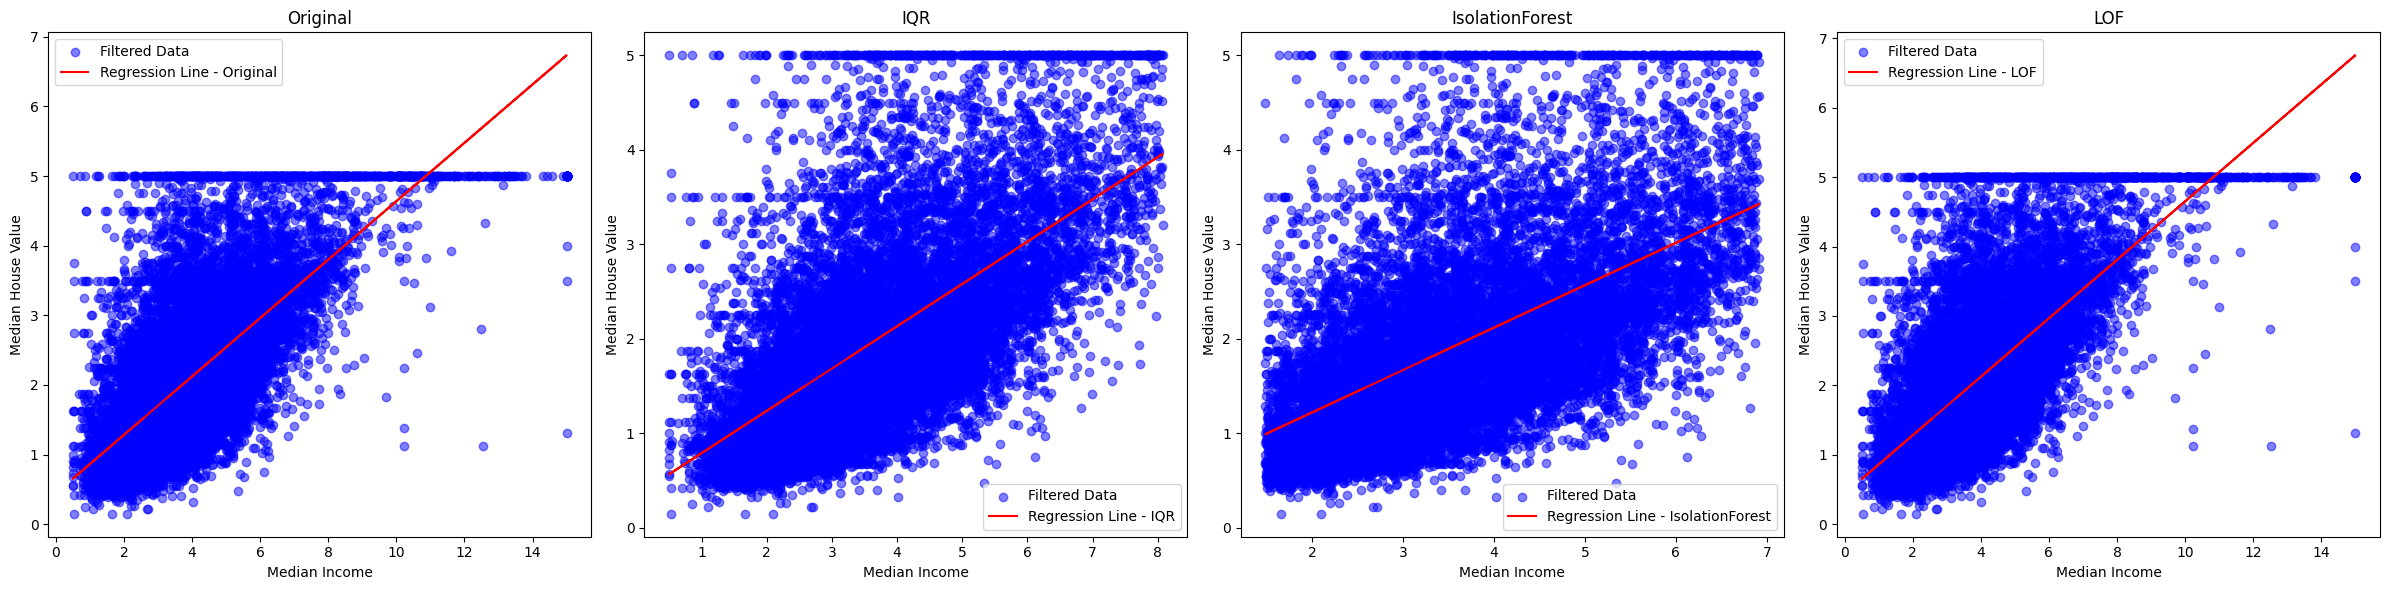

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# 데이터 로드 및 초기화
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="Target")
X = X[['MedInc']]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 이상치 제거 및 모델 학습/예측 함수
def detect_and_plot_outliers(method, X, y, ax):
    if method == 'Original':
        X_filtered = X
        y_filtered = y
    elif method == 'IQR':
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
        X_filtered = X[mask]
        y_filtered = y[mask]
    elif method == 'IsolationForest':
        iso = IsolationForest(contamination=0.1)
        mask = iso.fit_predict(X) != -1
        X_filtered = X[mask]
        y_filtered = y[mask]
    elif method == 'LOF':
        lof = LocalOutlierFactor()
        mask = lof.fit_predict(X) != -1
        X_filtered = X[mask]
        y_filtered = y[mask]

    # 선형 회귀 모델 훈련 및 예측
    model = LinearRegression()
    model.fit(X_filtered, y_filtered)
    y_pred = model.predict(X_filtered)

    # 시각화
    ax.scatter(X_filtered, y_filtered, color='blue', alpha=0.5, label='Filtered Data')
    ax.plot(X_filtered, y_pred, color='red', label='Regression Line - ' + method)
    ax.set_title(method)
    ax.set_xlabel('Median Income')
    ax.set_ylabel('Median House Value')
    ax.legend()

# 그래프 준비
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# 이상치 제거 방법별로 시각화
methods = ['Original', 'IQR', 'IsolationForest', 'LOF']
for ax, method in zip(axes, methods):
    detect_and_plot_outliers(method, X_train, y_train, ax)

plt.tight_layout()
plt.show()


### Cook's Distance
- 이상치 탐지 및 민감도 분석 할 때 어떤 데이터 포인트가 회귀 모델의 예측에 크게 기여학소 있는지? 확인하는 경우
- 통상적인 기준은 1이지만, 데이터에 따라서 거리 값이 달라질 순 있다.
- 기준값을 4/n 계산하거나, 4/(n-k-1) n은 관측값, k는 독립변수 수 임계값은 조정할 수 있다. 

--- 

- **낮은 Cook's Distance**: 해당 데이터 포인트가 모델에 미치는 영향이 작거나 없음을 나타냅니다. 이 데이터는 모델에 있어서 이상치가 아니거나 영향력이 낮습니다.
- **높은 Cook's Distance**: 이 데이터 포인트가 회귀선에 큰 영향을 미치고 있음을 나타냅니다. 일반적으로 Cook's Distance가 \( \frac{4}{n} \)보다 큰 경우, 이 데이터 포인트는 영향력 있는 이상치로 간주됩니다.

/var/folders/sz/167qwb595mqgwry5mm8685n00000gn/T/ipykernel_23271/2844229469.py:27: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(cooks_d, use_line_collection=True)


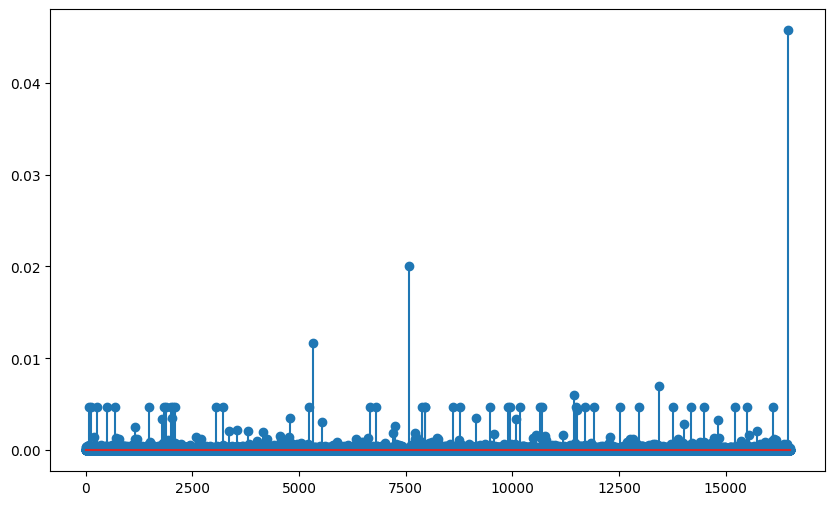

이상치 포인트 [    6    18    25    31    73    84   132   142   147   150   188   200
   233   259   267   292   296   325   348   354   357   364   384   418
   429   438   462   469   481   490   523   569   580   589   600   613
   621   638   657   678   691   712   770   792   801   816   819   824
   831   849   856   861   874   880   888   895   903   926   951   960
   966  1007  1020  1061  1077  1085  1098  1099  1116  1142  1144  1149
  1167  1173  1176  1194  1195  1200  1212  1221  1258  1269  1322  1324
  1332  1335  1365  1390  1419  1422  1429  1453  1461  1475  1491  1498
  1508  1509  1523  1575  1589  1596  1607  1622  1630  1666  1705  1726
  1756  1757  1779  1795  1820  1831  1860  1872  1906  1936  1984  1989
  2005  2009  2016  2020  2026  2045  2052  2056  2075  2084  2095  2109
  2125  2128  2140  2161  2181  2197  2206  2214  2224  2226  2232  2234
  2235  2250  2279  2291  2317  2336  2340  2347  2348  2362  2368  2382
  2406  2430  2436  2442  2443  2481  2517 

In [20]:
## IQR
data =fetch_california_housing()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.DataFrame(data.target, columns=['Target'])
X = X[['MedInc']]


X_train, X_test, y_train, y_test= train_test_split(X,y, test_size = 0.2, random_state=111)

## Cook's Distance

X_train = sm.add_constant(X_train)

#선형회귀 모델 학습

model = sm.OLS(y_train, X_train)
results = model.fit()

# Cook's Distance 계산

influence = results.get_influence()
cooks_d = influence.cooks_distance[0]

# 시각화

plt.figure(figsize=(10,6))
plt.stem(cooks_d, use_line_collection=True)
plt.show()

# 상위 이상치 포인트 식별
influential_points= np.where(cooks_d > 4 /len(X_train))[0]
print('이상치 포인트', influential_points)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# 데이터 로드 및 초기화
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["Target"])
X = X[['MedInc']]  # 'MedInc' 특성 사용

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 이상치 제거 및 모델 학습/예측 함수
def fit_ols_and_summary(method, X, y):
    if method == 'Original':
        X_filtered = X
        y_filtered = y
    elif method == 'IQR':
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
        X_filtered = X[mask]
        y_filtered = y[mask]
    elif method == 'IsolationForest':
        iso = IsolationForest(contamination=0.1)
        mask = iso.fit_predict(X) != -1
        X_filtered = X[mask]
        y_filtered = y[mask]
    elif method == 'LOF':
        lof = LocalOutlierFactor()
        mask = lof.fit_predict(X) != -1
        X_filtered = X[mask]
        y_filtered = y[mask]

    # 선형 회귀 모델 훈련 및 요약 출력
    X_filtered = sm.add_constant(X_filtered)  # adding a constant
    model = sm.OLS(y_filtered, X_filtered)
    results = model.fit()
    print(method + " Summary")
    print(results.summary())

# 이상치 제거 방법별로 OLS 요약 출력
methods = ['Original', 'IQR', 'IsolationForest', 'LOF']
for method in methods:
    fit_ols_and_summary(method, X_train, y_train)

Original Summary
                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                 1.506e+04
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        19:02:31   Log-Likelihood:                -20475.
No. Observations:               16512   AIC:                         4.095e+04
Df Residuals:                   16510   BIC:                         4.097e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4446      0.015   

### OLS Summary 출력 해석

```plaintext
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.XXX
Model:                            OLS   Adj. R-squared:                  0.XXX
Method:                 Least Squares   F-statistic:                     XXX.XX
Date:                YYYY-MM-DD HH:MM   Prob (F-statistic):           X.XXe-XX
Time:                        HH:MM:SS   Log-Likelihood:                -XXXX.XX
No. Observations:                 XXX   AIC:                             XXXX.X
Df Residuals:                     XXX   BIC:                             XXXX.X
Df Model:                          XX                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          X.XXXXX   X.XXXXX       X.XXX      X.XXX    [X.XXXXX    X.XXXXX]
X1             X.XXXXX   X.XXXXX       X.XXX      X.XXX    [X.XXXXX    X.XXXXX]
X2             X.XXXXX   X.XXXXX       X.XXX      X.XXX    [X.XXXXX    X.XXXXX]
...            ...       ...           ...        ...      ...         ...
==============================================================================
Omnibus:                       XX.XX   Durbin-Watson:                   X.XXX
Prob(Omnibus):                  X.XXX   Jarque-Bera (JB):                XX.XX
Skew:                           X.XXX   Prob(JB):                        X.XXX
Kurtosis:                       X.XXX   Cond. No.                         XXX.
==============================================================================
```

### 1. 상단 요약 정보

- **Dep. Variable**: 종속 변수의 이름.
- **Model**: 모델 유형 (OLS).
- **Method**: 모델을 적합시키기 위해 사용된 방법 (Least Squares).
- **Date**: 분석이 수행된 날짜.
- **Time**: 분석이 수행된 시간.
- **No. Observations**: 관측치의 수.
- **Df Residuals**: 잔차의 자유도 (관측치 수 - 독립 변수 수 - 1).
- **Df Model**: 모델의 자유도 (독립 변수의 수).
- **Covariance Type**: 공분산 유형 (보통 nonrobust).

### 2. 적합도 지표

- **R-squared**: 결정 계수 \(R^2\). 모델이 종속 변수의 변동성을 얼마나 설명하는지를 나타냅니다. 0과 1 사이의 값이며, 1에 가까울수록 모델이 데이터를 잘 설명합니다.
- **Adj. R-squared**: 수정된 결정 계수. \(R^2\)의 단점을 보완하여 독립 변수의 수를 고려한 지표입니다.
- **F-statistic**: 모델의 전체 유의성을 검정하기 위한 F 통계량. 높은 값일수록 모델이 유의미함을 나타냅니다.
- **Prob (F-statistic)**: F-검정의 p-값. 일반적으로 0.05 이하이면 모델이 유의미하다고 해석합니다.
- **Log-Likelihood**: 로그 우도. 모델이 데이터에 얼마나 적합한지를 나타내는 지표로, 값이 클수록 모델이 데이터를 잘 설명합니다.
- **AIC (Akaike Information Criterion)**: 모델의 적합성과 복잡성을 평가하는 지표. 값이 작을수록 좋은 모델을 의미합니다.
- **BIC (Bayesian Information Criterion)**: AIC와 유사하나, 더 엄격하게 모델의 복잡성을 벌점화합니다. 값이 작을수록 좋은 모델을 의미합니다.

### 3. 회귀 계수 테이블

- **coef**: 각 독립 변수의 회귀 계수. 종속 변수에 대한 각 독립 변수의 영향력을 나타냅니다.
- **std err**: 계수의 표준 오차. 회귀 계수의 불확실성을 나타냅니다.
- **t**: t-통계량. 각 회귀 계수가 0과 유의하게 다른지를 검정합니다.
- **P>|t|**: t-검정의 p-값. 일반적으로 0.05 이하이면 해당 계수가 유의미하다고 해석합니다.
- **[0.025 0.975]**: 회귀 계수의 95% 신뢰 구간. 이 구간이 0을 포함하지 않으면 해당 계수가 유의미하다고 해석합니다.

### 4. 진단 지표

- **Omnibus**: 잔차의 정규성을 검정하는 Omnibus 검정 통계량. 값이 작을수록 잔차가 정규분포를 따릅니다.
- **Prob(Omnibus)**: Omnibus 검정의 p-값. 일반적으로 0.05 이상이면 잔차가 정규분포를 따른다고 해석합니다.
- **Skew**: 잔차의 왜도. 0에 가까울수록 대칭적입니다.
- **Kurtosis**: 잔차의 첨도. 3에 가까울수록 정규분포에 가깝습니다.
- **Durbin-Watson**: 잔차의 자기 상관을 검정하는 Durbin-Watson 통계량. 값이 2에 가까울수록 자기 상관이 없습니다.
- **Jarque-Bera (JB)**: 잔차의 정규성을 검정하는 Jarque-Bera 통계량. 값이 작을수록 잔차가 정규분포를 따릅니다.
- **Prob(JB)**: Jarque-Bera 검정의 p-값. 일반적으로 0.05 이상이면 잔차가 정규분포를 따른다고 해석합니다.
- **Cond. No.**: 독립 변수의 조건수. 값이 높을수록 다중공선성의 문제가 있을 수 있습니다.
